# Analysis of FAST reconstructions with various trained models


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import ipyparallel as ipp

In [5]:
cluster = ipp.Cluster(engines="mpi", n=12)

In [6]:
rc = cluster.start_and_connect_sync()

Starting 12 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/12 [00:00<?, ?engine/s]

In [7]:
dv = rc[:]

In [8]:
%%px

from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

In [9]:
%%px --local
from pathlib import Path

import blosc2
import cv2
import fast.s26_analysis.utils as utils
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import skimage
import tifffile as tif
from cycler import cycler
from fast.utils.generate_scan_pattern import generate_scan_pattern as gcn
from fast.utils.img_loader import load_image_list_renormalize, renormalize
from markers_and_labels import KWARGS_PER_LABEL, LABELS
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
from scipy import interpolate
from tqdm.notebook import tqdm

In [10]:
%%px --local
frbh = lambda x, m: skimage.restoration.inpaint_biharmonic(x * m, (1 - m).astype("bool"))
frns = lambda x, m: cv2.inpaint(x * m, 1 - m, 10, cv2.INPAINT_NS)

In [11]:
%%px --local
def recons_scipy(orig_recons_this, mask_this, kernel="inverse_multiquadric", epsilon=1.0, **kwargs):
    mask_bool = mask_this.astype("bool")
    measured_idxs_this = np.array(np.where(mask_bool)).T
    unmeasured_idxs_this = np.array(np.where(~mask_bool)).T
    values_this = orig_recons_this[mask_bool]

    interp = interpolate.RBFInterpolator(
        measured_idxs_this, values_this, kernel=kernel, neighbors=10, smoothing=0.01, epsilon=epsilon, **kwargs
    )
    ynew = interp(unmeasured_idxs_this)
    # ynew = np.clip(ynew, a_max=np.inf, a_min=0)
    # ynew = ynew / ynew.max() * 100

    out = orig_recons_this.copy()
    out[~mask_bool] = ynew
    return out.astype("float32")

In [12]:
%%px --local
flakes = load_image_list_renormalize(
    ["/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/sims_paper/fused_full.tif"], img_format="tif"
)[0]

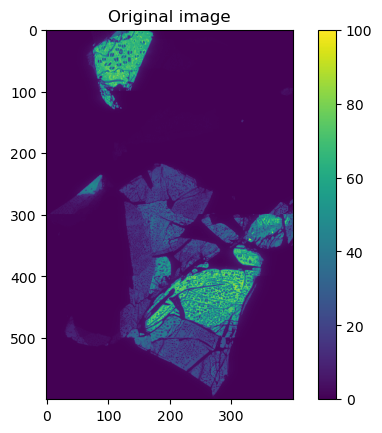

In [13]:
# Taking a generic image, then cropping and rescaling it
plt.figure()
plt.imshow(flakes)
plt.title("Original image")
plt.colorbar()
plt.show()

### Loading the data 

In [14]:
data_dir = Path("fast_sim_data/coarse_flakes/")
data_files = list(data_dir.glob("*.joblib"))
print(data_files)
data_files_filt = []
analysis_files = []
for d in data_files:
    if "analysis_results" in d.name:
        analysis_files.append(d)
        continue
    elif "all_combined_renorm" in d.name:
        continue
    data_files_filt.append(d)
data_files = data_files_filt

[PosixPath('fast_sim_data/coarse_flakes/cameraman_data.joblib'), PosixPath('fast_sim_data/coarse_flakes/camera_new_data.joblib'), PosixPath('fast_sim_data/coarse_flakes/clock_data.joblib'), PosixPath('fast_sim_data/coarse_flakes/female_data.joblib'), PosixPath('fast_sim_data/coarse_flakes/all_combined_c_2_data.joblib'), PosixPath('fast_sim_data/coarse_flakes/house_data.joblib'), PosixPath('fast_sim_data/coarse_flakes/jbeans_data.joblib'), PosixPath('fast_sim_data/coarse_flakes/lake_data.joblib'), PosixPath('fast_sim_data/coarse_flakes/male_data.joblib'), PosixPath('fast_sim_data/coarse_flakes/mandrill_data.joblib'), PosixPath('fast_sim_data/coarse_flakes/peppers_data.joblib'), PosixPath('fast_sim_data/coarse_flakes/plane_data.joblib'), PosixPath('fast_sim_data/coarse_flakes/analysis_results_with_inpainting.joblib'), PosixPath('fast_sim_data/coarse_flakes/all_combined_renorm_c_2_data.joblib'), PosixPath('fast_sim_data/coarse_flakes/analysis_results_without_bh_inpainting.joblib')]


In [15]:
data_files

[PosixPath('fast_sim_data/coarse_flakes/cameraman_data.joblib'),
 PosixPath('fast_sim_data/coarse_flakes/camera_new_data.joblib'),
 PosixPath('fast_sim_data/coarse_flakes/clock_data.joblib'),
 PosixPath('fast_sim_data/coarse_flakes/female_data.joblib'),
 PosixPath('fast_sim_data/coarse_flakes/all_combined_c_2_data.joblib'),
 PosixPath('fast_sim_data/coarse_flakes/house_data.joblib'),
 PosixPath('fast_sim_data/coarse_flakes/jbeans_data.joblib'),
 PosixPath('fast_sim_data/coarse_flakes/lake_data.joblib'),
 PosixPath('fast_sim_data/coarse_flakes/male_data.joblib'),
 PosixPath('fast_sim_data/coarse_flakes/mandrill_data.joblib'),
 PosixPath('fast_sim_data/coarse_flakes/peppers_data.joblib'),
 PosixPath('fast_sim_data/coarse_flakes/plane_data.joblib')]

In [16]:
analysis_files

[PosixPath('fast_sim_data/coarse_flakes/analysis_results_with_inpainting.joblib'),
 PosixPath('fast_sim_data/coarse_flakes/analysis_results_without_bh_inpainting.joblib')]

In [17]:
dv.scatter("data_file_per_label", data_files)

<AsyncResult(scatter): pending>

In [18]:
data_dir

PosixPath('fast_sim_data/coarse_flakes')

In [19]:
%%px
data_per_label = {}
for df in data_file_per_label:
    label = df.stem[:-5]
    if label == "all_combined_c_2":
        label = "combined"
    elif label == "all_combined_renorm_c_2":
        continue
    _t = joblib.load(df)
    try:
        _t[0]
    except:
        print(label)
        raise
    data_per_label[label] = {"ratios": _t[0], "recons": _t[1], "masks": _t[2], "erds": _t[3]}
    # joblib.dump(data_per_label[label], df, compress=4)

%px:   0%|          | 0/12 [00:00<?, ?tasks/s]

In [20]:
!du -hsc $data_dir

4.7G	fast_sim_data/coarse_flakes
4.7G	total


In [21]:
## Doing only the error calculations

In [22]:
%%px --local
reload_saved_results = True
inpainting = True

In [23]:
%%px
data_per_label.keys()

Out[7:8]: dict_keys(['lake'])

Out[4:8]: dict_keys(['combined'])

Out[1:8]: dict_keys(['camera_new'])

Out[3:8]: dict_keys(['female'])

Out[6:8]: dict_keys(['jbeans'])

Out[5:8]: dict_keys(['house'])

Out[0:8]: dict_keys(['cameraman'])

Out[11:8]: dict_keys(['plane'])

Out[2:8]: dict_keys(['clock'])

Out[10:8]: dict_keys(['peppers'])

Out[8:8]: dict_keys(['male'])

Out[9:8]: dict_keys(['mandrill'])

In [23]:
%%px
if reload_saved_results:
    assert False
skip = 5

results_per_label = {}
ratios = []
ratios_all = []


for _m, label in enumerate(data_per_label):
    if _m % skip != 0:
        continue
    results_per_label[label] = {}

    if inpainting:
        results_per_label[label]["recons_bh"] = []
    results_per_label[label]["indices"] = []
    results_per_label[label]["ssims"] = []
    results_per_label[label]["psnrs"] = []
    results_per_label[label]["rmses"] = []
    results_per_label[label]["ratios"] = []

    ratios_all = list(data_per_label[label]["ratios"])
    for _n, ratio_this in tqdm(enumerate(ratios_all)):
        if _n == 0 or _n % skip != 0:
            continue
        if ratio_this > 0.5:
            continue

        _r1 = data_per_label[label]["recons"][_n]
        _m1 = data_per_label[label]["masks"][_n].astype("bool")

        actual_max = flakes[_m1][np.argmax(_r1[_m1])]
        actual_min = flakes[_m1][np.argmin(_r1[_m1])]

        _r2 = renormalize(_r1, max_value=255, min_value=0).astype(
            "float32"
        )  # actual_max, min_value=actual_min).astype('float32')

        if inpainting:
            # _r2 = frbh(_r2, _m1)
            # _r2 = recons_scipy(_r2, _m1, kernel='inverse_quadratic')
            _r2 = frns(_r2, _m1.astype("uint8"))
            _r2[_r2 > 255] = 255
            _r2[_r2 < 0] = 0
        _r2 = renormalize(_r2, max_value=actual_max, min_value=actual_min)
        results_per_label[label]["ssims"].append(skimage.metrics.structural_similarity(flakes, _r2, data_range=100))
        results_per_label[label]["psnrs"].append(skimage.metrics.peak_signal_noise_ratio(flakes, _r2, data_range=100))
        results_per_label[label]["rmses"].append(skimage.metrics.normalized_root_mse(flakes, _r2))
        results_per_label[label]["indices"].append(_n)

        results_per_label[label]["ratios"].append(ratio_this)
        if inpainting:
            results_per_label[label]["recons_bh"].append(
                _r2,
            )
    for k, v in results_per_label[label].items():
        results_per_label[label][k] = np.array(v)

[8:execute]
---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
Cell In[9], line 2
      1 if reload_saved_results:
----> 2     assert False
      3 skip = 5
      5 results_per_label = {}

AssertionError: 
[2:execute]
---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
Cell In[9], line 2
      1 if reload_saved_results:
----> 2     assert False
      3 skip = 5
      5 results_per_label = {}

AssertionError: 
[0:execute]
---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
Cell In[9], line 2
      1 if reload_saved_results:
----> 2     assert False
      3 skip = 5
      5 results_per_label = {}

AssertionError: 
[5:execute]
-------------------------------------------------------------------

AlreadyDisplayedError: 12 errors

In [24]:
save_dir = Path("fast_sim_data") / "coarse_flakes"
if not reload_saved_results:
    dv.gather("results_per_label")

    results_all = {}
    for d in dv["results_per_label"]:
        results_all.update(d)

    save_dir.mkdir(exist_ok=True)
    if inpainting:
        save_fname = save_dir / "analysis_results_with_inpainting.joblib"
    else:
        save_fname = save_dir / "analysis_results_without_bh_inpainting.joblib"
    joblib.dump(results_all, save_fname, compress=5)
else:
    if inpainting:
        results_all = joblib.load(save_dir / "analysis_results_with_inpainting.joblib")
    else:
        results_all = joblib.load(save_dir / "analysis_results_without_bh_inpainting.joblib")

In [25]:
a1 = results_all["cameraman"]["recons_bh"][0]

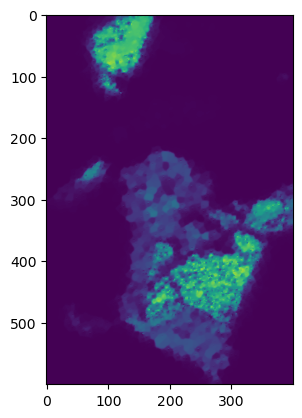

In [26]:
plt.imshow(a1.reshape(flakes.shape))

(0.0, 40.0)

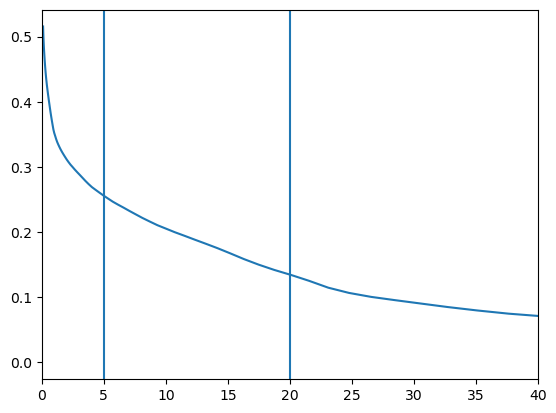

In [ ]:
plt.plot(thresholds[:-1], 1 - counts)
# plt.xscale('log')
plt.axvline(20)
plt.axvline(5)
plt.xlim(0, 40)

In [27]:
figures_dir = Path("paper_figures_and_results/coarse")
figures_dir.mkdir(exist_ok=True)

In [28]:
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

In [29]:
results_all = {k: results_all[k] for k in sorted(results_all)}

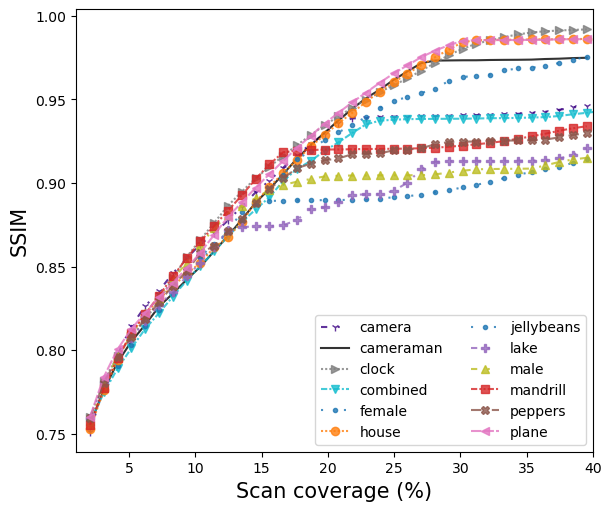

In [43]:
plt.figure(figsize=[6, 5], constrained_layout=True)
for ix, _name in enumerate(results_all):
    label = LABELS[_name] if _name in LABELS else _name
    plot_kwargs = KWARGS_PER_LABEL[label]
    plot_kwargs["alpha"] = 0.8
    plt.plot(
        results_all[_name]["ratios"] * 100,
        results_all[_name]["ssims"],
        label=label,
        # markevery=0.15,
        **plot_kwargs,
    )
plt.xlabel("Scan coverage (%)", fontsize=15)
plt.ylabel("SSIM", fontsize=15)
plt.legend(loc="best", ncols=2)

# plt.text(28, 0.8, r'$27\%$', size=18)
# plt.axvline(27, ls=':')
plt.xlim([1, 40])
plt.savefig(f"{figures_dir}/ssims.svg", bbox_inches="tight", dpi=600, transparent=True)
plt.savefig(f"{figures_dir}/ssims.pdf", bbox_inches="tight", dpi=600, transparent=True)
plt.show()

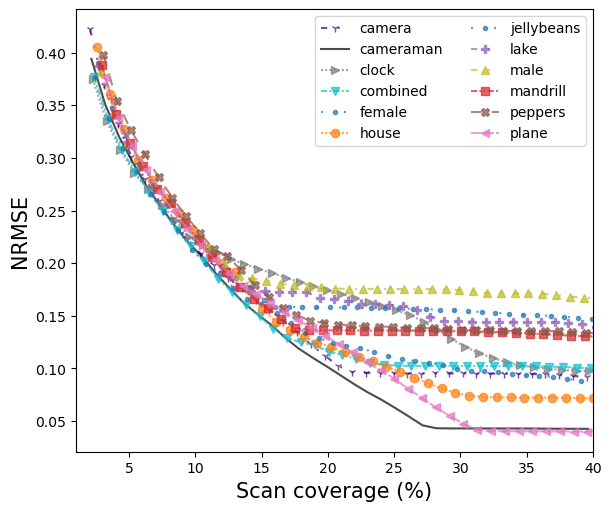

In [53]:
plt.figure(figsize=[6, 5], constrained_layout=True)
for ix, _name in enumerate(results_all):
    label = LABELS[_name] if _name in LABELS else _name
    plot_kwargs = KWARGS_PER_LABEL[label]
    plot_kwargs["alpha"] = 0.7
    plt.plot(
        results_all[_name]["ratios"] * 100 + ix * 0.1,
        results_all[_name]["rmses"],
        label=label,
        # markevery=0.15,
        **plot_kwargs,
    )
plt.xlabel("Scan coverage (%)", fontsize=15)
plt.ylabel("NRMSE", fontsize=15)
plt.legend(loc="best", ncols=2)

# plt.text(28, 0.8, r'$27\%$', size=18)
# plt.axvline(27, ls=':')
plt.xlim([1, 40])
plt.savefig(f"{figures_dir}/nrmses.svg", bbox_inches="tight", dpi=600, transparent=True)
plt.savefig(f"{figures_dir}/nrmses.pdf", bbox_inches="tight", dpi=600, transparent=True)
plt.show()

In [32]:
dv["results_all"] = results_all

In [33]:
%%px
masks_per_label = {}
for label in data_per_label:
    masks = data_per_label[label]["masks"]
    indices = results_all[label]["indices"]

    match label:
        case "combined1":
            label2 = "combined"
        case "combined2":
            continue
        case _:
            label2 = label
    masks_per_label[label2] = masks[indices]

%px:   0%|          | 0/12 [00:00<?, ?tasks/s]

In [34]:
masks_per_label_list = dv.gather("masks_per_label")

In [35]:
masks_per_label = {}
for m in masks_per_label_list:
    masks_per_label.update(m)

In [36]:
ratios_to_plot = [0.15]

In [37]:
idxs_to_plot = {}
for k, v in results_all.items():
    idxs_to_plot[k] = [np.argmin(np.abs(v["ratios"] - r)) for r in ratios_to_plot]

In [38]:
idxs_to_plot

{'camera_new': [12],
 'cameraman': [12],
 'clock': [12],
 'combined': [12],
 'female': [12],
 'house': [12],
 'jbeans': [12],
 'lake': [12],
 'male': [12],
 'mandrill': [12],
 'peppers': [12],
 'plane': [12]}

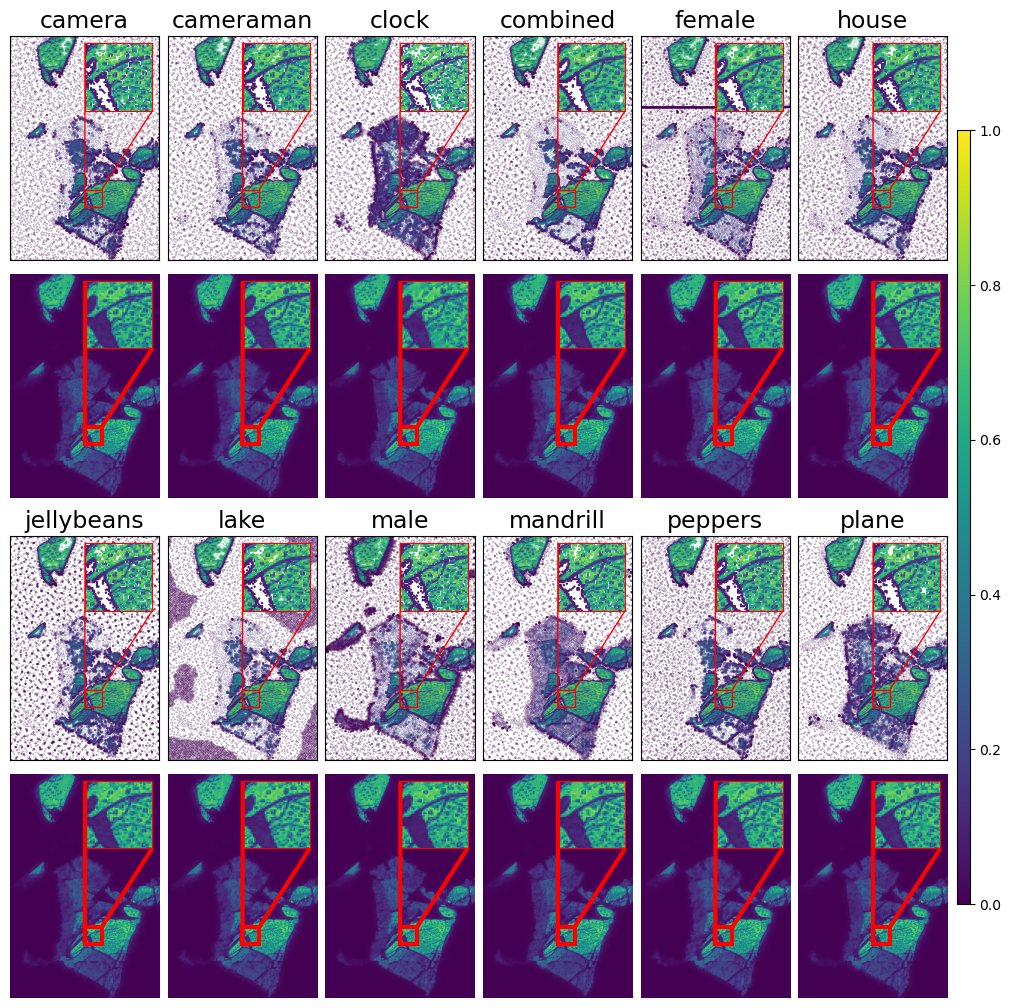

In [51]:
cmap = mpl.colormaps.get_cmap("viridis").copy()
norm = plt.Normalize(0, 1.0)
rasterized = True

for n, r in enumerate(ratios_to_plot):
    fig, axs = plt.subplots(4, 6, figsize=[10, 10], constrained_layout=True)
    axs = axs.flatten()
    r_perc = r * 100
    for iy, label in enumerate(results_all):
        ix = idxs_to_plot[label][n]
        mask = masks_per_label[label][ix]
        recons = results_all[label]["recons_bh"][ix]
        # axs[iy * 2].imshow(masks[label][ix])
        #
        # axs[iy * 2].axis('off')
        ypoints, xpoints = np.where(mask)

        rmax = flakes[ypoints, xpoints].max()
        rmin = flakes[ypoints, xpoints].min()

        recons_renorm = renormalize(recons, min_value=rmin, max_value=rmax) / 100
        ints = recons_renorm[ypoints, xpoints]

        _ic = (iy // 6) * 6 * 2 + iy % 6
        cax = axs[_ic].scatter(
            xpoints, ypoints, c=ints, norm=norm, cmap=cmap, s=0.1, rasterized=rasterized, marker=".", zorder=0
        )
        cax.set_edgecolors = None
        axs[_ic].set_aspect("equal")
        # plt.text(6, 20, f'{percent}%', fontsize=25, c='red')
        # plt.title(f'{label} ({percent}%)', fontsize=16)
        axs[_ic].set_xticks([])
        axs[_ic].set_yticks([])
        axs[_ic].set_xlim(0, 399)
        axs[_ic].set_ylim(0, 599)

        title = LABELS[label] if label in LABELS else label
        axs[_ic].set_title(title, fontsize=17)
        axs[_ic].invert_yaxis()
        # for im in axs[iy * 2].get_images():
        #    im.clim(0, flakes.max())

        inset_axes = zoomed_inset_axes(axs[_ic], 4, loc=1)
        for spine in inset_axes.spines.values():
            spine.set_edgecolor("red")

        inset_axes.scatter(
            xpoints,
            ypoints,
            c=ints,
            s=0.5,
            norm=norm,
            cmap=cmap,
            rasterized=rasterized,
            facecolor="white",
            zorder=1,
        )

        inset_axes.set_xlim([200, 245])
        inset_axes.set_ylim([410, 455])
        inset_axes.set(xticks=[], yticks=[])
        inset_axes.invert_yaxis()
        inset_axes.patch.set_alpha(1.0)

        mark_inset(axs[_ic], inset_axes, loc1=2, loc2=4, fc="none", ec="red", linewidth=1.0)

        cim = axs[_ic + 6].imshow(recons_renorm, rasterized=rasterized)
        axs[_ic + 6].axis("off")

        inset_axes = zoomed_inset_axes(axs[_ic + 6], 4, loc=1)
        for spine in inset_axes.spines.values():
            spine.set_edgecolor("red")

        inset_axes.imshow(recons_renorm, norm=norm, cmap=cmap, rasterized=rasterized)
        inset_axes.set_xlim([200, 245])
        inset_axes.set_ylim([410, 455])
        inset_axes.set(xticks=[], yticks=[])
        inset_axes.invert_yaxis()

        mark_inset(axs[_ic + 6], inset_axes, loc1=2, loc2=4, fc="none", ec="red", linewidth=3.0)

    # plt.delaxes(axs[-1])
    # plt.delaxes(axs[-7])
    fig.colorbar(cim, ax=axs, shrink=0.8, pad=0.01, aspect=60)
    # fig.suptitle(f"{r_perc:3.0f}%")
    plt.savefig(f"{figures_dir}/coarse_comparisons_{r_perc:2.0f}.svg", bbox_inches="tight", dpi=300, transparent=True)
    plt.savefig(f"{figures_dir}/coarse_comparisons_{r_perc:2.0f}.pdf", bbox_inches="tight", dpi=300, transparent=True)
    plt.show()

In [ ]:
!du -hsc $figures_dir/*

6.4M	paper_figures_and_results/coarse/coarse_comparisons_15.pdf
11M	paper_figures_and_results/coarse/coarse_comparisons_ 15.svg
12M	paper_figures_and_results/coarse/coarse_comparisons_15.svg
32K	paper_figures_and_results/coarse/nrmses.pdf
124K	paper_figures_and_results/coarse/nrmses.svg
32K	paper_figures_and_results/coarse/ssims.pdf
124K	paper_figures_and_results/coarse/ssims.svg
30M	total


In [54]:
!du -hsc $figures_dir/*

6.4M	paper_figures_and_results/coarse/coarse_comparisons_15.pdf
11M	paper_figures_and_results/coarse/coarse_comparisons_ 15.svg
12M	paper_figures_and_results/coarse/coarse_comparisons_15.svg
32K	paper_figures_and_results/coarse/nrmses.pdf
124K	paper_figures_and_results/coarse/nrmses.svg
32K	paper_figures_and_results/coarse/ssims.pdf
124K	paper_figures_and_results/coarse/ssims.svg
30M	total


In [99]:
rc.shutdown(hub=True)

engine set stopped 1679949315: {'exit_code': 0, 'pid': 1246115, 'identifier': 'ipengine-1679949314-f43s-1679949315-1245940'}
Controller stopped: {'exit_code': 0, 'pid': 1246035, 'identifier': 'ipcontroller-1679949314-f43s-1245940'}
